The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [1]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 102.3 MB/s eta 0:

In [2]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [4]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]


# Tokenization	
tokenizer.fit_on_texts(corpus)
#print(tokenizer.word_index['<unk>'])

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']
#print(eos)
#print(tokenizer.index_word[sos])

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [6]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [7]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 4, 6169, 10, 4, 222, 4544, 23, 222, 5777, 3099, 5, 8, 893, 3]
shuffled sentecen:  [2, 893, 4, 4544, 222, 8, 4, 3099, 5, 23, 5777, 222, 10, 6169, 3]


Let us look at detokenized data:

In [8]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> the growth from the 2018 school year to the 2019 school year 2019 was 2 <end>
shuffled sentence:  <start> to 2019 2018 school the from growth year 2019 the the 2 school was year <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


Depending from the model you plan to build, you might require padding the input sequence

In [10]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
# x_test is used to control the data augmentation so its padding is computed further on 
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')


In [11]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

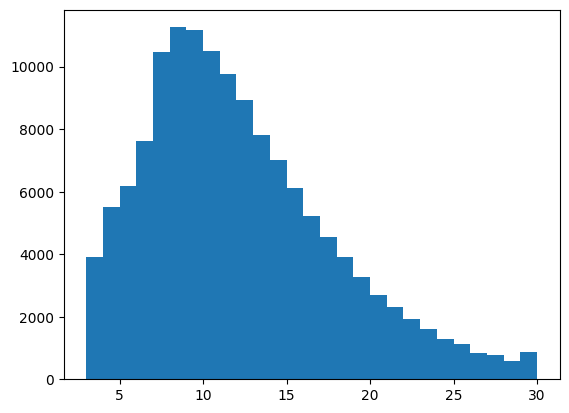

In [12]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [13]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(s),len(p)))

Let's do an example.

In [14]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

# Data augmentation

I extend the train set from the same dataset by keeping the same vocabulary created before. I filter out all the sequences with unknown character (number 1 in the tokenizer)

In [15]:
data_extended = dataset['train'][20000:]['text']
corpus = []
for elem in data_extended:
  corpus +=elem.lower().replace("\n", "").split(".")[:]
corpus = ['<start> '+s+' <end>' for s in corpus]
original_data_extension = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen)) if 1 not in sen]
shuffled_data_extension = [random.sample(s[1:-1],len(s)-2) for s in original_data_extension]
shuffled_data_extension = [[sos]+s+[eos] for s in shuffled_data_extension]

x_train_extension = pad_sequences(original_data_extension, maxlen=max_sequence_len, padding='post')
c_train_extension = pad_sequences(shuffled_data_extension, maxlen=max_sequence_len, padding='post')

In [16]:
print("x_train_extension size:", len(x_train_extension))

x_train_extension size: 373306


Then I load another dataset for augment more the train set. Even here the vocabulary is unchanged and sentences with unknowns are filtered out.

In [17]:
dataset2 = load_dataset("wikipedia", "20220301.en")

Downloading:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/20.3G [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.en/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
data_augmented = dataset2['train'][:50000]['text']

corpus_aug = []
for elem in data_augmented:
  corpus_aug += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus_aug))

corpus_aug = ['<start> '+s+' <end>' for s in corpus_aug]
augmented_data = [sen for sen in tokenizer.texts_to_sequences(corpus_aug) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen)) if 1 not in sen]
augmented_data = list(set(map(tuple, augmented_data)).difference(set(map(tuple, x_test)))) #it filters only the sentences that are not present in the test set
shuffled_augmented_data = [random.sample(s[1:-1],len(s)-2) for s in augmented_data]
shuffled_augmented_data = [[sos]+s+[eos] for s in shuffled_augmented_data]


corpus dim:  6596585


In [19]:
max_sequence_len_aug = max([len(x) for x in augmented_data])

x_train_augmented = pad_sequences(augmented_data, maxlen=max_sequence_len_aug, padding='post')
c_train_augmented = pad_sequences(shuffled_augmented_data, maxlen=max_sequence_len_aug, padding='post')

#Now we can padd x_test
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')

In [20]:
print("x_train_augmented size:", len(x_train_augmented))

x_train_augmented size: 594262


I create the validation test and then I concatenate all the training data

In [21]:
x_train_, x_val, c_train_, c_val = train_test_split(x_train, c_train, test_size=0.1, random_state=42)

In [22]:
x_train_extended = np.concatenate([x_train_, x_train_extension, x_train_augmented])
c_train_extended = np.concatenate([c_train_, c_train_extension, c_train_augmented])

In [23]:
print("The size of the entire train set is", len(x_train_extended), "sentences")

The size of the entire train set is 1054067 sentences


In [24]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf


In [46]:
BATCH_SIZE = 512
BUFFER_SIZE = tf.data.AUTOTUNE

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((c_train_extended, x_train_extended)) 
    .batch(BATCH_SIZE)
    .prefetch(BUFFER_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((c_val, x_val))
    .batch(BATCH_SIZE)
    .prefetch(BUFFER_SIZE))

def process_text(context, target):
    targ_in = target[:,:-1]
    targ_out = target[:,1:]
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [26]:
# constants
VOCAB_SIZE = 10000
VOCABULARY = ['<pad>'] + list(tokenizer.word_index.keys())[:VOCAB_SIZE-1]
SENTENCE_LENGTH = 32

# hyperparameters
UNITS = 256

# Model

I decided to inplement a Transformer because it is very good in modeling sequential data, such as natural languages. This choice is what guided me in augmenting the training data, since transformers generally requires a substantial amount of data to perform well. The model implemented in the notbook follows the structure described in the paper "Attention Is All You Need".

### The embedding and positional encoding layer

In [27]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [28]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

### Attention layers

- The **GlobalSelfAttention** layer: is responsible for processing the context sequence, and propagating information along its length
- The **CrossAttention** layer: connects the encoder and decoder
- The **CausalSelfAttention** layer: does a similar job as the global self attention layer, for the output sequence

In [29]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


### Feed forward layer

In [30]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

### The encoder

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

### The decoder

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [33]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

### The transformer

In [34]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [67]:
# HYPERPARAMETERS
num_layers = 5 #number of layers
d_model = 128 #embedding dimension
dff = 128 #feed forward dimension
num_heads = 15 #nmber of heads 
dropout_rate = 0.1 #dropout rate

In [68]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=VOCAB_SIZE,
    dropout_rate=dropout_rate)

In [69]:
for (c, x), y in train_ds.take(1):
  break

In [70]:
output = transformer((c, x))


In [71]:
transformer.summary()

Model: "transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  6392320   
                                                                 
 decoder_3 (Decoder)         multiple                  11338240  
                                                                 
 dense_95 (Dense)            multiple                  1290000   
                                                                 
Total params: 19,020,560
Trainable params: 19,020,560
Non-trainable params: 0
_________________________________________________________________


# Training

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.
In particular I use the **AdamW** algorithm that combines the features of Adam with a specific form of regularization called weight decay. Weight decay is a mechanism for penalizing model weights during training to prevent overfitting. This means that the model weights are reduced proportionally when updating the weights. This helps control the complexity of the model and can lead to better generalization.

In [72]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [73]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.AdamW(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9, weight_decay=0.005)

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. I use the **SparseCategoricalCrossentropy** loss function

In [74]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [80]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])


In [76]:
stop_training_2 = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", patience=8, restore_best_weights=True)

In [81]:
history = transformer.fit(train_ds, epochs = 20, validation_data = val_ds, shuffle= True, callbacks = [stop_training_2]) 

Epoch 1/20
2059/2059 [==============================] - 565s 256ms/step - loss: 4.9309 - masked_accuracy: 0.3434 - val_loss: 2.1658 - val_masked_accuracy: 0.6117
Epoch 2/20
2059/2059 [==============================] - 394s 191ms/step - loss: 1.6078 - masked_accuracy: 0.6630 - val_loss: 1.1935 - val_masked_accuracy: 0.7062
Epoch 3/20
2059/2059 [==============================] - 394s 191ms/step - loss: 1.1284 - masked_accuracy: 0.7231 - val_loss: 0.9233 - val_masked_accuracy: 0.7530
Epoch 4/20
2059/2059 [==============================] - 394s 191ms/step - loss: 0.9207 - masked_accuracy: 0.7586 - val_loss: 0.8021 - val_masked_accuracy: 0.7753
Epoch 5/20
2059/2059 [==============================] - 395s 192ms/step - loss: 0.8150 - masked_accuracy: 0.7782 - val_loss: 0.7440 - val_masked_accuracy: 0.7874
Epoch 6/20
2059/2059 [==============================] - 394s 191ms/step - loss: 0.7467 - masked_accuracy: 0.7916 - val_loss: 0.6990 - val_masked_accuracy: 0.7955
Epoch 7/20
2059/2059 [======

# Inference

I encode the input shuffled sentence using the tokenizer. The decoder input is initialized to the '[START]' token, then the decoder outputs the predictions by looking at the encoder output and its own output (self-attention). I concatenate the predicted token to the decoder input and pass it to the decoder. In this way the decoder predicts the next token based on the previous tokens it predicted, until the end of the sequence.

In [82]:
def tokens_to_text(tokens): 
    result = tf.strings.regex_replace(tokens, '<[^>]+>','')
    result = tf.strings.regex_replace(result, ' +', ' ')  # Normalize multiple spaces to a single space
    result = tf.strings.strip(result)
    return result

class Predict(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer
    self.start = tokenizers.word_index['<start>']
    self.end = tokenizers.word_index['<end>']

  def __call__(self,test):
    predictions = []
    total_iter = tf.shape(test)[0] // BATCH_SIZE + 1
    res = []
    for i in range(total_iter):
         start_time = time.time()
         st_idx = i*BATCH_SIZE
         end_idx = i*BATCH_SIZE + BATCH_SIZE
         batch_data = test[st_idx:end_idx] 
         results = self.predict(batch_data)
         end_time = time.time()
         total_time = end_time - start_time
         print(f"total time for {i} iterations = {round(total_time,2)} seconds")
         batch_sentences = tokens_to_text(results)
         res.append(batch_sentences)
    return res

  def predict(self, encoder_input, max_length=32):
    
    batch_size = encoder_input.shape[0]
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

    start = np.array(self.start, ndmin=1)
    output_array = output_array.write(0, tf.tile(start, [batch_size]))

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[:, 0])
      
      end_mask = tf.reduce_any(tf.equal(predicted_id, self.end), axis=-1)
      if tf.reduce_all(end_mask):
            break

    output = tf.transpose(output_array.stack())
    tokens_list = output.numpy().tolist()
    sentence = [tokenizer.sequences_to_texts([row])[0] for row in tokens_list]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return sentence


In [83]:
translator = Predict(tokenizer, transformer)

In [84]:
def evaluate(y_test_to_evaluate, results):
    i = 0
    scores = []
    for j in range(len(results) - 1):
        for k in range(BATCH_SIZE):
            scores.append(score(
                results[j][k].numpy().decode("utf-8"), y_test_to_evaluate[i] 
            ))
            i = i + 1
    return  np.mean(scores)

In [106]:
randomizer = Random(42)
EXAMPLES_TO_TEST = 6000
N_BATCHES = int(np.ceil(EXAMPLES_TO_TEST / BATCH_SIZE))

indexes = list(range(len(y_test)))
randomizer.shuffle(indexes)
indexes = indexes[:N_BATCHES * BATCH_SIZE]

In [107]:
result = translator(c_test[indexes])

total time for 0 iterations = 7.85 seconds
total time for 1 iterations = 7.79 seconds
total time for 2 iterations = 7.75 seconds
total time for 3 iterations = 7.72 seconds
total time for 4 iterations = 7.75 seconds
total time for 5 iterations = 7.69 seconds
total time for 6 iterations = 7.77 seconds
total time for 7 iterations = 7.77 seconds
total time for 8 iterations = 7.66 seconds
total time for 9 iterations = 7.72 seconds
total time for 10 iterations = 7.61 seconds
total time for 11 iterations = 7.68 seconds
total time for 12 iterations = 0.42 seconds


In [108]:
def replacing(string):
  while "<pad>" in string:
    string = string.replace("<pad>","")
  string = string.replace("<end>","")
  string = string.rstrip()
  return string


In [109]:
y_test_to_evaluate = [replacing(s) for s in tokenizer.sequences_to_texts(y_test[indexes])]

In [110]:
print("The score is: ",evaluate(y_test_to_evaluate, result))

The score is:  0.5847629082065534


In [99]:
transformer.save_weights('transformer_weights_.h5')

# Conclusion

Given a score of 0.585 we can say that the model is able to reconstruct pretty well the sentences. So the Transformer tourns out to be a good choice and augmentation at the same; without collecting more date I was able only to abtain a score of at most 0.5.